In [80]:
import re
import spacy
import numpy as np
import pandas as pd

import xml.etree.ElementTree as ET 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [2]:
path = input('Chemin :\n')
if path.lower() == 'i':
    path = '/Users/admin1/Documents/deft_2009 2/data/'
else:
    path = ''
    

# Récupération des données de train

In [3]:
def extract_train(path):
    '''Fonction qui permet l'extraction du texte et du parti pour le corpus de train'''
    list_target =[] 
    list_text =[]
    tree= ET.parse(path)
    root= tree.getroot()
    doc= root.findall('doc')
    for doc in root.findall('doc') :
        parti= doc.find(".//PARTI")
        val= parti.get("valeur")
        list_target.append(val)

        texte = doc.find('texte')
        if texte is not None:
            textesanspar = re.sub(r'\xa0|\n|<texte>|</texte>|<p>|</p>', '', ET.tostring(texte, 'utf-8').decode('utf-8'))
            textesanspar = re.sub(r'[^\w\s\']|[0-9]', ' ', textesanspar)
            list_text.append(textesanspar) 
    return list_text, list_target

## Extraction des données du train

In [4]:
train_text_en, train_target_en = extract_train(f'{path}train/deft09_parlement_appr_en.xml')
train_text_fr, train_target_fr = extract_train(f'{path}train/deft09_parlement_appr_fr.xml')
train_text_it, train_target_it = extract_train(f'{path}train/deft09_parlement_appr_it.xml')

In [77]:
print(len(train_target_en))
print(len(train_target_fr))
print(len(train_target_it))

19370
19370
19370


# Récupération des données de test

## Extraction du texte

In [7]:
def extract_text_test(path):
    '''Fonction qui permet l'extraction du texte pour le corpus de test'''
    liste_text=[]
    tree= ET.parse(path)
    root= tree.getroot()
    docs= root.findall('doc')
    for doc in docs:
        texte = doc.find('texte')
        if texte is not None:
            textesanspar = re.sub(r'\xa0|\n|<texte>|</texte>|<p>|</p>', '', ET.tostring(texte, 'utf-8').decode('utf-8'))
            textesanspar = re.sub(r'[^\w\s\']|[0-9]', ' ', textesanspar)
            liste_text.append(textesanspar)
    return liste_text


In [8]:
test_text_en = extract_text_test(f'{path}test/deft09_parlement_test_en.xml')
test_text_fr = extract_text_test(f'{path}test/deft09_parlement_test_fr.xml')
test_text_it = extract_text_test(f'{path}test/deft09_parlement_test_it.xml')

In [75]:
print(len(test_text_en))
print(len(test_text_fr))
print(len(test_text_it))

12917
12917
12917


## Extraction du parti

In [11]:
def extract_train_test(path):
    '''Fonction qui permet l'extraction du parti pour le test'''
    liste_target = []
    with open(path) as file:
        for line in file:
            enliste=line.strip('\n').split('\t')
            liste_target.append(enliste[1])
    return liste_target

In [12]:
test_target_en = extract_train_test(f'{path}ref/deft09_parlement_ref_en.txt')
test_target_fr = extract_train_test(f'{path}ref/deft09_parlement_ref_fr.txt')
test_target_it = extract_train_test(f'{path}ref/deft09_parlement_ref_it.txt')

# 1. Modèles pour toutes les langues 

## Vectorisation

### Récupération des listes de stops words de Spacy


In [15]:
en = spacy.load("en_core_web_sm")
fr = spacy.load("fr_core_news_sm")
it = spacy.load("it_core_news_sm")

stopwordsen = list(en.Defaults.stop_words)
stopwordsfr = list(fr.Defaults.stop_words)
stopwordsit = list(it.Defaults.stop_words)

### Vectorisation du train et test

In [16]:
stopwords=[*stopwordsen,*stopwordsfr,*stopwordsit]
train_text=[*train_text_en,*train_text_fr,*train_text_it]
test_text=[*test_text_en,*test_text_fr,*test_text_it]

In [17]:
print(len(train_text))
print(train_text[58109])

58110
   Signor Presidente  intervengo per un breve commento  La relazione sulle associazioni industriali di cui sono responsabile è stata inserita all ordine del giorno di questa settimana senza che io ne sapessi nulla e soprattutto contrariamente a quanto era stato concordato tra Parlamento e autorità competenti  L ho appreso nel corso di una telefonata che ho ricevuto da un giornalista del Times di Londra  che intendeva rivolgermi alcune domande in proposito  Quando ho chiesto come fosse potuto succedere  l ufficio competente del Parlamento ha affermato che era stato fatto con il consenso dei gruppi  Quando mi sono rivolto ai gruppi  mi è stato detto che erano stati i servizi del Parlamento  Ciò non getta certo una luce positiva sul Parlamento  Ora apprendo   naturalmente con gratitudine   che la relazione può essere presentata solo con il consenso del relatore  alcuni gruppi sanno che sono ancora in corso importanti negoziati  In pratica  però  sarebbe stato molto meglio che tutto 

In [18]:
vectorizer = TfidfVectorizer(stop_words = stopwords, max_df=0.9, min_df=0.001)
#fit_transforme pour le train 
X_train = vectorizer.fit_transform(train_text)
#transforme pour le test pour la surapprendre 
X_test = vectorizer.transform(test_text)
# Chaque mots qui apparaissent en MIN
features = vectorizer.get_feature_names_out()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'll', 'neuf', 'nient', 'qu', 'quelqu', 've'] not in stop_words.
  warnings.warn(


In [19]:
X_train= X_train.toarray()
X_test=X_test.toarray()

## Preparation des targets

- On remarque qu'il existe des targets vides dans le corpus pour lesquelles le texte associé ne contient que les balises paragraphes. On crée ainsi une classe vide pour ces textes.

In [20]:
target_labels = ["GUE-NGL", "PSE", "PPE-DE", "ELDR", "Verts-ALE"]

for indice, element in enumerate(test_target_en):
    if element not in target_labels:
        print(indice)
        

2601
12171


In [21]:
def dico(target_text):
    target=[]
    dico={'GUE-NGL':0,'PSE':1 ,'PPE-DE':2,'ELDR':3,'Verts-ALE':4, '':5}
    for parti in target_text:
        for cle,val in dico.items():
            if cle == parti:
                target.append(val)
    return np.array(target)


In [22]:
y_train =dico([*train_target_en,*train_target_fr,*train_target_it])
y_test = dico([*test_target_en,*test_target_fr,*test_target_it])

In [23]:
y_train_en= dico(train_target_en)
y_train_fr= dico(train_target_fr)
y_train_it = dico(train_target_it)

y_test_en= dico(test_target_en)
y_test_fr= dico(test_target_fr)
y_test_it= dico(test_target_it)

## Visualisation des données 

In [24]:
result = pd.DataFrame(
    data=X_train, 
    index=y_train,
    columns= features
)

result


,abandon,abandoned,abandonner,abattage,abbandonare,abbandonato,abbandono,abbattimento,abbreviated,abbreviato,...,événement,événements,êtes,êtres,île,îles,œil,œuvre,œuvrer,εu
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


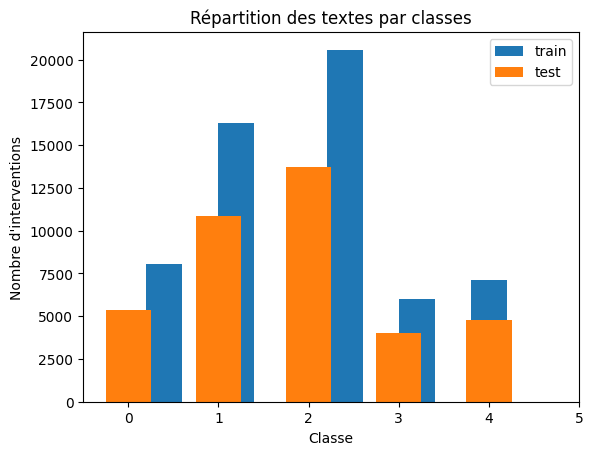

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y_train, align="right", label="train") 
plt.hist(y_test, align="left", label="test")
plt.legend()
plt.xlabel("Classe")
plt.ylabel("Nombre d'interventions")
plt.title("Répartition des textes par classes") 
plt.show()

## Classifieurs

### SVM

In [154]:
clf = LinearSVC()
clf.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [155]:
clf.predict(X_test)

array([1, 2, 4, ..., 1, 0, 4])

In [156]:
clf.score(X_test, y_test)

0.6467962117106655

In [157]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      5379
           1       0.60      0.61      0.61     10881
           2       0.64      0.75      0.69     13713
           3       0.68      0.48      0.56      4017
           4       0.65      0.50      0.57      4755
           5       0.00      0.00      0.00         6

    accuracy                           0.65     38751
   macro avg       0.55      0.51      0.53     38751
weighted avg       0.65      0.65      0.64     38751



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

### Naive Bayes

In [159]:
MNB = MultinomialNB(alpha=0.1)
MNB.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [160]:
MNB.predict(X_test)

array([1, 2, 4, ..., 2, 0, 2])

In [161]:
y_pred = MNB.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.43      0.53      5379
           1       0.50      0.43      0.46     10881
           2       0.46      0.85      0.60     13713
           3       0.96      0.03      0.06      4017
           4       0.63      0.10      0.17      4755
           5       0.00      0.00      0.00         6

    accuracy                           0.50     38751
   macro avg       0.54      0.31      0.30     38751
weighted avg       0.58      0.50      0.44     38751



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

### Random Forest

In [ ]:
rfc =  RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
rfc.predict(X_test)

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
rfc.score(X_test, y_test)

0.3538747387164202

In [ ]:
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5379
           1       0.00      0.00      0.00     10881
           2       0.35      1.00      0.52     13713
           3       0.00      0.00      0.00      4017
           4       0.00      0.00      0.00      4755
           5       0.00      0.00      0.00         6

    accuracy                           0.35     38751
   macro avg       0.06      0.17      0.09     38751
weighted avg       0.13      0.35      0.18     38751



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# 2. Modèles pour chaque langue 

### Vectorisation 

In [65]:
def vectorization(datatrain, datatest,stopWords):
    vectorizer = TfidfVectorizer(stop_words = stopWords, min_df=8, max_df= 50000)
    X_train = vectorizer.fit_transform(datatrain)
    # Chaque mots qui apparaissent en MIN
    X_test = vectorizer.transform(datatest)
    features = vectorizer.get_feature_names_out()
    return X_train, X_test, features

In [66]:
X_train_en, X_test_en, features_en = vectorization(train_text_en,test_text_en, stopwordsen)
X_train_fr, X_test_fr, features_fr = vectorization(train_text_fr,test_text_fr, stopwordsfr)
X_train_it, X_test_it, features_it = vectorization(train_text_it,test_text_it, stopwordsit)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gl', 'nient'] not in stop_words.
  warnings.warn(


In [67]:
print(X_train_en.shape)

(19370, 13294)


### Classifieurs 

#### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [28]:
rf = RandomForestClassifier()
#rf.fit(X_train_en, y_train_en)
#y_pred = rf.predict(X_test_en)


- Test des paramètres du modèle sur le corpus anglais

In [29]:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [30]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_en, y_train_en)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  44.3s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  44.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  45.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=12

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time= 3.6min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 6.2min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 6.2min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time= 6.3min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=False, max

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

In [68]:
rfen= RandomForestClassifier(bootstrap=False, max_depth=500, min_samples_split=5, n_estimators=800)
rfen.fit(X_train_en, y_train_en)
y_pred = rfen.predict(X_test_en)

In [69]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_en, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7851668344042735


In [47]:
rffr= RandomForestClassifier(bootstrap=False, max_depth=500, min_samples_split=5, n_estimators=800)
rffr.fit(X_train_fr, y_train_fr)
y_pred = rffr.predict(X_test_fr)

In [48]:
accuracy = accuracy_score(y_test_fr, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7821475574823875


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test_en, y_pred))
print(rfen.score(X_test_en, y_test_en))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1793
           1       0.86      0.71      0.78      3627
           2       0.66      0.96      0.78      4571
           3       0.99      0.64      0.78      1339
           4       1.00      0.62      0.77      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.79     12917
   macro avg       0.74      0.61      0.66     12917
weighted avg       0.83      0.79      0.79     12917

0.7851668344042735


In [50]:
rfit= RandomForestClassifier(bootstrap=False, max_depth=500, min_samples_split=5, n_estimators=800)
rfit.fit(X_train_it, y_train_it)
y_pred = rfit.predict(X_test_it)

In [51]:
accuracy = accuracy_score(y_test_it, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7871796856855307


In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test_fr, y_pred))
print(rffr.score(X_test_fr, y_test_fr))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.15      0.11      0.13      1793
           1       0.28      0.23      0.25      3627
           2       0.35      0.51      0.42      4571
           3       0.10      0.06      0.08      1339
           4       0.14      0.09      0.11      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.28     12917
   macro avg       0.17      0.17      0.16     12917
weighted avg       0.25      0.28      0.26     12917

0.7821475574823875


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test_it, y_pred))
print(rfit.score(X_test_it, y_test_it))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.14      0.11      0.12      1793
           1       0.28      0.23      0.26      3627
           2       0.36      0.53      0.43      4571
           3       0.12      0.08      0.09      1339
           4       0.12      0.08      0.09      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.29     12917
   macro avg       0.17      0.17      0.17     12917
weighted avg       0.25      0.29      0.26     12917

0.7871796856855307


#### SVC

In [23]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [ ]:
classifier= SVC()
classifier.fit(X_train_en, y_train_en)
y_pred = classifier.predict(X_test_en)


In [31]:
#resultat SVC 

print(classification_report(y_test_en, y_pred))
print(classifier.score(X_test_en, y_test_en))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1793
           1       0.73      0.75      0.74      3627
           2       0.67      0.91      0.77      4571
           3       0.99      0.48      0.65      1339
           4       0.96      0.54      0.69      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.75     12917
   macro avg       0.71      0.57      0.61     12917
weighted avg       0.79      0.75      0.74     12917



/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7495548501974143


In [21]:
#SVM Anglais 

clf = LinearSVC(dual=False)
clf.fit(X_train_en, y_train_en)
y_pred = clf.predict(X_test_en)


NameError: name 'LinearSVC' is not defined

In [37]:
#résultat SVM.linear 
print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1793
           1       0.69      0.71      0.70      3627
           2       0.71      0.81      0.76      4571
           3       0.79      0.61      0.68      1339
           4       0.75      0.63      0.68      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.73     12917
   macro avg       0.63      0.59      0.60     12917
weighted avg       0.73      0.73      0.73     12917

0.7306650150963846


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
clf = LinearSVC(dual=False)
clf.fit(X_train_fr, y_train_fr)
y_pred = clf.predict(X_test_fr)

print(classification_report(y_test_fr, y_pred))
print(clf.score(X_test_fr, y_test_fr))


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1793
           1       0.71      0.73      0.72      3627
           2       0.73      0.82      0.77      4571
           3       0.81      0.63      0.71      1339
           4       0.78      0.64      0.71      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.75     12917
   macro avg       0.64      0.60      0.62     12917
weighted avg       0.75      0.75      0.75     12917

0.7481613377719285


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
clf = LinearSVC(dual=False)
clf.fit(X_train_it, y_train_it)
y_pred = clf.predict(X_test_it)

print(classification_report(y_test_it, y_pred))
print(clf.score(X_test_it, y_test_it))


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1793
           1       0.72      0.73      0.73      3627
           2       0.73      0.82      0.78      4571
           3       0.80      0.63      0.71      1339
           4       0.78      0.66      0.71      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.75     12917
   macro avg       0.64      0.60      0.62     12917
weighted avg       0.75      0.75      0.75     12917

0.7514902841217


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
classifier= SVC()
classifier.fit(X_train_it, y_train_it)
y_pred = classifier.predict(X_test_it)


In [ ]:
print(classification_report(y_test_it, y_pred))
print(classifier.score(X_test_it, y_test_it))

In [ ]:
#Settings parameters for SVM ? si marche pas enlever 'poly' 

In [ ]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

clf= GridSearchCV(SVC(gamma='auto'), {'C':[1,5,10,15,20], 'kernel':['rbf','linear']})
clf.fit(X_train_en, y_train_en)

df= pd.DataFrame(clf.cv_results_)


In [ ]:
#aussi pour grisearch
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}

clf = SVC()

grid_search = GridSearchCV(clf, param_grid, random_state= 0)

grid_search.fit(X_train_en, y_train_en)

print(grid_search.bestparams)
#et c ca pour avoir les meilleurs paramètres

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import  make_scorer

In [32]:
def finetunning_NBM(X_train, y_train):
    parameters= {
    'alpha':[0, 0.25, 0.5, 0.75, 1],
    'force_alpha': [False,True],
    'fit_prior':[False,True]
    }
    clf= GridSearchCV(MultinomialNB(),parameters,scoring= make_scorer(f1_score),refit= True)
    clf.fit(X_train, y_train)
    return clf.best_params_

In [33]:
best_param_en= finetunning_NBM(X_train_en, y_train_en)
best_param_fr= finetunning_NBM(X_train_fr,y_train_fr)
best_param_it= finetunning_NBM(X_train_it, y_train_it)

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_p

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_p

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_p

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

In [34]:
## Pour l'anglais 
MNB = MultinomialNB(**best_param_en)
MNB.fit(X_train_en, y_train_en)

y_pred = MNB.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(MNB.score(X_test_en, y_test_en))

              precision    recall  f1-score   support

           0       0.68      0.63      0.66      1793
           1       0.56      0.62      0.59      3627
           2       0.68      0.61      0.64      4571
           3       0.58      0.60      0.59      1339
           4       0.53      0.60      0.56      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.61     12917
   macro avg       0.51      0.51      0.51     12917
weighted avg       0.62      0.61      0.61     12917

0.6120616242161493


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision

In [35]:
## Pour le français 

MNB = MultinomialNB(**best_param_fr)
MNB.fit(X_train_fr, y_train_fr)

y_pred = MNB.predict(X_test_fr)

print(classification_report(y_test_fr, y_pred))
print(MNB.score(X_test_fr, y_test_fr))

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      1793
           1       0.59      0.66      0.62      3627
           2       0.69      0.68      0.68      4571
           3       0.63      0.62      0.62      1339
           4       0.60      0.61      0.60      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.65     12917
   macro avg       0.54      0.53      0.54     12917
weighted avg       0.65      0.65      0.65     12917

0.6494542076333514


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision

In [36]:
## Pour l'italien 

MNB = MultinomialNB(**best_param_it)
MNB.fit(X_train_it, y_train_it)

y_pred = MNB.predict(X_test_it)

print(classification_report(y_test_it, y_pred))
print(MNB.score(X_test_it, y_test_it))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68      1793
           1       0.59      0.66      0.62      3627
           2       0.68      0.68      0.68      4571
           3       0.68      0.60      0.64      1339
           4       0.61      0.60      0.61      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.65     12917
   macro avg       0.55      0.53      0.54     12917
weighted avg       0.65      0.65      0.65     12917

0.6491445382054657


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision

In [21]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


In [22]:
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}

clf = SVC()

grid_search = RandomizedSearchCV(clf, param_grid,  n_iter=5, random_state= 0, scoring= make_scorer(f1_score), refit=True, n_jobs=2)

grid_search.fit(X_train_en, y_train_en)

print(gridsearch.best_params_)


NameError: name 'X_train_en' is not defined

In [156]:
print(grid_search.best_params_)

{'kernel': 'rbf', 'gamma': 0.1, 'C': 1}


In [157]:
clf = SVC(**grid_search.best_params_)
clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      0.33      0.48      1793
           1       0.56      0.23      0.33      3627
           2       0.41      0.96      0.57      4571
           3       1.00      0.01      0.02      1339
           4       0.94      0.01      0.02      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.45     12917
   macro avg       0.63      0.26      0.24     12917
weighted avg       0.64      0.45      0.36     12917

0.4509561043585972


In [23]:
from sklearn.svm import LinearSVC


In [26]:
param_grid= {
    'penalty':['l1','l2'],
    'loss':['hinge', 'squared_hinge'],
    'dual':[False],
    'C': [0.0, 0.25, 0.5, 0.75, 1],
    'multi_class': ['ovr', 'crammer_singer'],
    'fit_intercept': [False,True],
    'intercept_scaling': [0.0, 0.25, 0.5, 0.75, 1.0]
}

In [27]:
grid_search = RandomizedSearchCV(LinearSVC(), param_grid, n_iter=5, scoring= make_scorer(f1_score), refit=True)

grid_search.fit(X_train_en, y_train_en)


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anacon

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/home/amina/anaconda3/lib/python3.10/site-packag

/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(estimator=LinearSVC(), n_iter=5,
                   param_distributions={'C': [0.0, 0.25, 0.5, 0.75, 1],
                                        'dual': [False],
                                        'fit_intercept': [False, True],
                                        'intercept_scaling': [0.0, 0.25, 0.5,
                                                              0.75, 1.0],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'multi_class': ['ovr',
                                                        'crammer_singer'],
                                        'penalty': ['l1', 'l2']},
                   scoring=make_scorer(f1_score))

In [28]:

print(grid_search.best_params_)

{'penalty': 'l1', 'multi_class': 'crammer_singer', 'loss': 'hinge', 'intercept_scaling': 0.75, 'fit_intercept': False, 'dual': False, 'C': 0.75}


In [ ]:
def finetunning_SVCLinear(X_train, y_train):
    parameters= {
    'penalty':['l1','l2'],
    'loss':['hinge', 'squared_hinge'],
    'dual':[False],
    'C': [0.0, 0.25, 0.5, 0.75, 1],
    'multi_class': ['ovr', 'crammer_singer'],
    'fit_intercept': [False,True],
    'intercept_scaling': [0.0, 0.25, 0.5, 0.75, 1.0]
    }
    clf= RandomizedSearchCV(LinearSVC(), param_grid, n_iter=5, scoring= make_scorer(f1_score), refit=True)

    clf.fit(X_train, y_train)
    return clf.best_params_

In [ ]:
best_paramz_en= finetunning_SVCLinear(X_train_en, y_train_en)
best_paramz_fr= finetunning_SVCLinear(X_train_fr,y_train_fr)
best_paramz_it= finetunning_SVCLinear(X_train_it, y_train_it)

In [ ]:
#anglais
SVCL = LinearSVC(**best_param_en)
SVCL.fit(X_train_en, y_train_en)

y_pred = SVCL.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(SVCL.score(X_test_en, y_test_en))

In [ ]:
#francais
SVCL = LinearSVC(**best_param_fr)
SVCL.fit(X_train_fr, y_train_fr)

y_pred = SVCL.predict(X_test_fr)

print(classification_report(y_test_fr, y_pred))
print(SVCL.score(X_test_fr, y_test_fr))

In [ ]:
#italien
SVCL = LinearSVC(**best_param_it)
SVCL.fit(X_train_it, y_train_it)

y_pred = SVCL.predict(X_test_it)

print(classification_report(y_test_it, y_pred))
print(SVCL.score(X_test_it, y_test_it))

In [29]:
param= {'penalty': 'l1', 'multi_class': 'crammer_singer', 'loss': 'hinge', 'intercept_scaling': 0.75, 'fit_intercept': False, 'dual': False, 'C': 0.75}

clf= LinearSVC(**grid_search.best_params_)

clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1793
           1       0.66      0.63      0.65      3627
           2       0.67      0.79      0.72      4571
           3       0.73      0.53      0.62      1339
           4       0.70      0.57      0.63      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.69     12917
   macro avg       0.59      0.55      0.56     12917
weighted avg       0.69      0.69      0.68     12917

0.6865371216226678


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0

In [ ]:
clf= LinearSVC(dual=False)

clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


#### Grid search pour SVC, mais les résultats ne sont pas concluant, j'ai mis 
#### dans une variable 'param' les paramètres que randomizedSearch ont donnés

In [ ]:
grid_search = RandomizedSearchCV(LinearSVC(), param_grid, n_iter=3, scoring= make_scorer(f1_score), refit=True)

grid_search.fit(X_train_en, y_train_en)


In [47]:
param= {'penalty': 'l2', 'multi_class': 'crammer_singer', 'loss': 'hinge', 'intercept_scaling': 1.0, 'fit_intercept': True, 'dual': False, 'C': 0.75}


clf= LinearSVC(**grid_search.best_params_)

clf.fit(X_train_en, y_train_en)

y_pred = clf.predict(X_test_en)

print(classification_report(y_test_en, y_pred))
print(clf.score(X_test_en, y_test_en))


              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1793
           1       0.66      0.63      0.65      3627
           2       0.66      0.79      0.72      4571
           3       0.75      0.54      0.62      1339
           4       0.71      0.57      0.63      1585
           5       0.00      0.00      0.00         2

    accuracy                           0.69     12917
   macro avg       0.59      0.54      0.56     12917
weighted avg       0.69      0.69      0.68     12917

0.685685530695982


/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amina/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0